In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
%matplotlib inline

#deal with encoding errors:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")

import data_prep
from yleana_util import *

In [221]:
FN = 'data/diag 2015-06-28.csv'
rawDF = pd.read_csv(FN)
HOME_DIR = './'
TEST_ID = 'YL_1_PP_SAT_S0114'
df = data_prep.clean_data(rawDF)
df = data_prep.addNumConcepts(df)

In [162]:
def makeHTMLTable(df):
    return df.to_html(index=False)\
    .replace('<table border="1" class="dataframe">','<table class="table table-striped">') # use bootstrap styling
    
def groupData(df,columns,statVar):
    '''
    group the data by the columns, aggregating the statVar with sum, mean, std
    args:
        df: dataframe
        columns:columns to group by
        statVar: column to aggregate.  
    '''
    subDF = df[columns+[statVar]]
    grouped = subDF.groupby(columns,sort=True)
    groupedDF = grouped.agg([np.size,np.sum, np.mean])[statVar]
    groupedDF = groupedDF.reset_index()
    groupedDF['mean'] = groupedDF['mean'].round(2)
    return groupedDF

def buildFocusTable(df,studentID,testID,subject,passingThreshold=0.6,minWrong=5,toHTML=True):
    '''
    Get a data frame of concepts in which this student is farthest behind the rest of the class, weighted by concept weight.
    These are recommendations for further study
    args:
        df: raw dataframe
        testID: test from which you want to build a recommendation table
        studentID:student ID integer
        subject: math, reading, sentence, or writing
        passingThreshold: minimum score to pass 
        minWrong: minimum number of wrong answers to make a recommendation
        toHTML: convert table to HTML (default True)
    returns:
        rec: Dataframe of concepts in which this student is farthest behind the rest of the class,
                ranked by the difference between this student's % correct and the class avg.
    '''
    
    #optionally specify a testID, otherwise use all tests
    if testID is not None:
        df = df.loc[df['testID']==testID,:].copy()
    df = df.loc[df['subject']==subject,:]
        
    #list of concepts
    conceptsDF = getConceptWeight(df)
    
    #get student and class performance on each concept
    studentPerf,classPerf = getClassAvg(df,columns=['studentID','subject','concept'],statVar='correct',passingThreshold=passingThreshold)
    classPerf = classPerf.sort('numStudentsGivenConcept')
    q1 = pd.merge(studentPerf,classPerf,on=['subject','concept'])
    q2 = pd.merge(q1,conceptsDF, how='left',on=['subject','concept'])
    rec = q2[['studentID','subject','concept','conceptWeight','wrong','score','classAvg']].copy()
    rec['scoreDiff']=rec['score'] - rec['classAvg']
    rec['weightedScoreDiff'] = rec['scoreDiff']*rec['conceptWeight']
    
    #only recommend areas where the student got at least a few wrong
    rec = rec[rec['wrong']>=minWrong]
    
    for col in ['conceptWeight','score','classAvg','scoreDiff']:
        rec[col] = rec[col].round(2)
    rec.sort('weightedScoreDiff',ascending=True, inplace=True)
    rec = rec.loc[rec['studentID']==studentID].head()
    
    rec.drop(['studentID','subject'],axis='columns',inplace=True)
    
    if toHTML:
        return makeHTMLTable(rec)
    else:
        return rec

In [277]:
def getPerfByColumns(df,columns,statVar):
    '''
    Get score by concept, by student, along with whether the score is above a passing threshold
    args:
        df: clean dataframe
        columns: columns to group by
        statVar: statistic your'e measuring
        passingThreshold: minimum score to pass
    returns: 
        perf: dataframe listing scores by student by concept
    '''
    perf = groupData(df,columns,statVar)
    perf['wrong']=perf['size'] - perf['sum']

    perf.rename(columns={'size':'numQuestions','sum':'numCorrect','mean':'score'},inplace=True)    
    return perf

def buildOpportunityTable(df,studentID,testID,subject,difficulty,toHTML=True):
    '''
    Get a dataframe of concepts in which this student got the most wrong answers, 
    optionally specifying a difficulty level.
    args:
        df: raw dataframe
        testID: test from which you want to build a recommendation table
        firstName:first name of student
        subject: math, reading, sentence, or writing
        passingThreshold: minimum score to pass 
        minWrong: minimum number of wrong answers to make a recommendation
        toHTML: convert table to HTML (default True)
    returns:
        rec: Dataframe of concepts in which this student is farthest behind the rest of the class,
                ranked by the difference between this student's % correct and the class avg.
    '''
    #optionally specify a testID, otherwise use all tests
    if testID is not None:
        df = df.loc[df['testID']==testID,:]
        
    if difficulty is not None:
        df = df.loc[df['difficulty']==difficulty,:]
        if difficulty == 'easy':
            df = df.loc[(df['studentAnswer']!='BLANK') & (df['studentAnswer']!='')]
    df = df.loc[df['subject']==subject,:]
    df = df.loc[df['studentID'] == studentID,:]

    rec = getPerfByColumns(df,['testID','subject','concept'],'correct')
    rec = rec.sort('wrong',ascending=False).head()
    
    rec.drop(['testID','subject'],axis='columns',inplace=True)
    
    if toHTML:
        return makeHTMLTable(rec)
    else:
        return rec

In [278]:
def buildRecTable(df,studentID,testID,subject,homeDir):
    titles = {'math':'Math', 
          'reading':'Reading Comprehension',
          'writing':'Writing',
          'sentence':'Sentence Completion'
         }
    
    focus = buildFocusTable(df,studentID,testID,subject,toHTML=False)
    opportunity = buildOpportunityTable(df,studentID,testID,subject,difficulty=None)
    careless = buildOpportunityTable(df,studentID,testID,subject,difficulty='easy')

    focusHTML = makeHTMLTable(focus)
    focusList = list(focus['concept'])
    figName = conceptPerformanceOverTime(df,studentID,subject,focusList,homeDir)
    
    print titles[subject]
    html_string = '''
    <a class="anchor" id="'''+subject+'''" ></a>
    <div class="row">
    </div>
    <div class="row">
        <div class="col-md-12">
            <h2>'''+ titles[subject] +'''</h2>
            <h3>Focus Concepts</h3>
            <p>Concepts where the student is furthest behind the rest of the class.\
            The plot shows progress on these concepts since the beginning of the course.</p>
            <img src=../plots/'''+figName+'''>
            '''+ focusHTML +'''
        </div>
    </div>
    <div class="row">
        <div class="col-md-6">
            <h3>Opportunity Concepts</h3>
            <p>Concepts where the student got the most wrong answers or blanks</p>
            '''+ opportunity +'''
        </div>
        <div class="col-md-6">
            <h3>Careless Errors</h3>
            <p>"Easy" concepts where the student got the most wrong answers (Not including blanks)</p>
            '''+ careless +'''
        </div>
    </div>
    <hr>
    '''
    
    return html_string    

In [279]:
def buildStudentScoreReport(df,studentID,testID,homeDir):
    studentName = df.loc[df['studentID']==studentID,'firstName'].iloc[0] + '_' + df.loc[df['studentID']==studentID,'lastName'].iloc[0]
    
    #create table dictionaries
    recTables = ''

    #Loop through subjects
    for subject in ['sentence','reading','math','writing']:
        recTables=recTables + buildRecTable(df,studentID,testID, subject,homeDir)

    print recTables
    html_string = '''
<html>
    <head>
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.1/css/bootstrap.min.css">
        <style>body{ margin:0 100; background:whitesmoke; }</style>
        <style>
        table th, table td {
            font-size : 77%;
        }
        hr {
            border: 1px solid #bbb;
        }
        body {
            padding-top:50px;
        }
        a.anchor {
            display: block; 
            position: relative; 
            top: -40px; 
            visibility: hidden;
        }
        </style>
    </head>
    <body>
        <div class="navbar navbar-inverse navbar-fixed-top" role="navigation">
          <div class="container">
            <div class="navbar-header">
              <button type="button" class="navbar-toggle" data-toggle="collapse" data-target=".navbar-collapse">
                <span class="sr-only">Toggle navigation</span>
                <span class="icon-bar"></span>
                <span class="icon-bar"></span>
                <span class="icon-bar"></span>
              </button>
              <a class="navbar-brand" href="#">Yleana.org</a>
            </div>
            <div class="collapse navbar-collapse">
              <ul class="nav navbar-nav">
                <li><a href="#sentence">Sentence Completion</a></li>
                <li><a href="#reading">Reading Comprehension</a></li>            
                <li><a href="#math">Math</a></li>
                <li><a href="#writing">Writing</a></li>
              </ul>
            </div><!--/.nav-collapse -->
          </div>
        </div>
 
        <h1>Score Report for '''+ studentName.replace('_',' ') + '''</h1>
        <p>Student ID: ''' + str(studentID) + '&nbsp Test ID: ' + testID + '''</h2>
        '''+ recTables +'''
    </body>
</html>'''
    
    outName = studentName+'_'+str(studentID)+'_'+testID+'.html'
    index = '</br> <a href="http://www.yleana.org/Stats/reports/'+outName+'">'+outName+'</a>'
    with open(homeDir + "index.html", "a") as myfile:
        myfile.write(index)
    
    f = open(homeDir + 'reports/'+outName,'w')
    f.write(html_string)
    f.close()

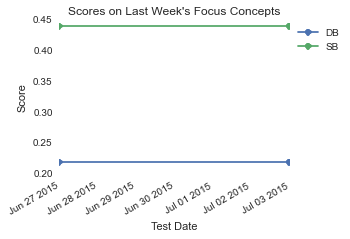

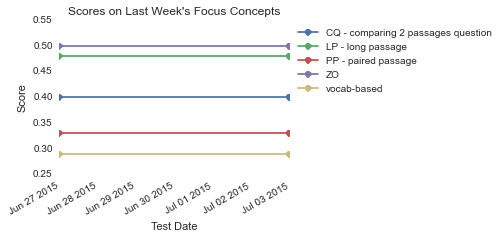

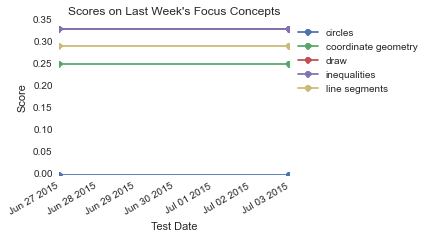

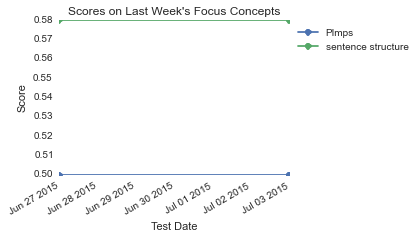

In [280]:
buildStudentScoreReport(dfx2,1142,TEST_ID,HOME_DIR)

In [108]:
def buildAllStudentReports(df,testID):
    for studentID in df['studentID'].unique():
        buildStudentScoreReport(df,studentID,testID)

buildAllStudentReports(df,testID=TEST_ID)

In [132]:
df['testDate'] = datetime.datetime(2015, 6, 27)
df2 = df.copy()
df2['testDate'] = datetime.datetime(2015, 7, 3)
print df.shape
dfx2 = df.append(df2,ignore_index=True)

In [275]:
def plotTrends(perfDF,studentID,subject,homeDir):
    fig, ax = plt.subplots()
    concepts = perfDF.concept.unique()
    for concept in concepts:
        d = perfDF[perfDF['concept']==concept]
        x = d['testDate']
        y = d['score']
        plt.plot(x,y,'-o')

    plt.ylabel('Score')
    plt.xlabel('Test Date')
    plt.title('Scores on Last Week\'s Focus Concepts')
    plt.legend(concepts,bbox_to_anchor=(1, 1), loc=2)
    plt.tight_layout()
    plt.subplots_adjust(right=.65)
    fig.autofmt_xdate()
    
    #fig.set_size_inches(width,height)
    figName = 'FocusTrends_'+subject+'_'+str(studentID)+'.png'
    figPath = homeDir + 'plots/' + figName
    fig.set_size_inches(6, 3)
    fig.savefig(figPath,dpi=100)
    return figName

'FocusTrends_math_1142.png'

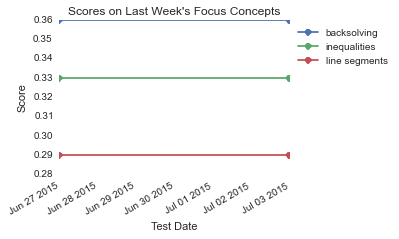

In [276]:
def conceptPerformanceOverTime(df,studentID,subject,concepts,homeDir):
    '''
    Assuming we have dates of tests, measure performance of a given concept over time
    '''
    
    #build a table that has the following columns: concept testID testDate score
    df = df.loc[df['studentID'] == studentID,:]
    
    #filter down to the interesting concepts
    df = df.loc[df['concept'].isin(concepts)]

    perf = getPerfByColumns(df,['testID','testDate','concept'],'correct')
    perf = perf[['testID','testDate','concept','score']]
    figName = plotTrends(perf,studentID,subject,homeDir)
    return figName

conceptPerformanceOverTime(dfx2,1142,'math',focusList,HOME_DIR)

In [8]:
STUDENT_ID,FIRST_NAME,LAST_NAME,TEST_ID,QUESTION,SECTION,SUBJECT,CORRECT_ANSWER,STUDENT_ANSWER,DIFFICULTY,CONCEPT =\
('studentUniqueID','firstName','lastName','testName','testQuestionNumber','testSectionNumber','type','correctAnswer','answer','difficultyLevel','concept')
print FIRST_NAME